<a href="https://colab.research.google.com/github/cheffjiu/pytorch-tutorials-zh/blob/main/pyg/1_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 68.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Introduction: Hands-on Graph Neural Networks

最近，图深度学习已成为深度学习领域最热门的研究方向之一。
在此，**图神经网络（GNN）**旨在将经典的深度学习概念推广到非规则结构数据（与图像或文本不同），并使神经网络能够对对象及其关系进行推理。

这是通过遵循一种简单的**神经消息传递方案**来实现的，其中，图 $\mathbf{G} = (\mathbf{V}, \mathbf{E})$ 中所有节点 $v \in \mathbf{V}$ 的节点特征 $\mathbf{x}_v^{(\ell)}$ 通过聚合来自其邻居 $\mathbf{N}(v)$ 的局部信息进行迭代更新：

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathbf{N}(v) \right\} \right)
$$

本教程将通过基于**[PyTorch Geometric（PyG）库](https://github.com/rusty1s/pytorch_geometric)** 的图神经网络，向你介绍一些关于图深度学习的基本概念。
PyTorch Geometric是流行的深度学习框架[PyTorch](https://pytorch.org/)的扩展库，包含各种方法和工具，以简化图神经网络的实现。

跟随[基普夫等人（2017年）](https://arxiv.org/abs/1609.02907)的研究，让我们通过一个简单的图结构示例——著名的[**扎卡里空手道俱乐部网络**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)，深入探索图神经网络（GNN）的世界。该图描绘了一个由34名空手道俱乐部成员组成的社交网络，并记录了俱乐部外有互动的成员之间的联系。在此，我们感兴趣的是检测因成员互动而形成的社群。

PyTorch Geometric通过[`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets)子包，提供了对该数据集的便捷访问：

In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


初始化[`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) 数据集后, 首先，我们可以考察它的一些属性。
例如，我们可以看到这个数据集恰好包含 **一个图**，并且该数据集中的每个节点都被赋予了一个 **34维特征向量**（它唯一地描述了空手道俱乐部的成员）。
此外，该图恰好包含 **4个类别**，这些类别代表每个节点所属的社区。

现在，让我们更详细地研究一下图的底层细节：

In [3]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


在PyTorch Geometric中，每个图都由单个[`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data)对象表示，该对象包含描述其图表示的所有信息。
我们可以随时通过`print(data)`打印数据对象，以获取有关其属性及其形状的简短摘要：
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
我们可以看到，这个`data`对象包含4个属性：
(1)`edge_index`属性保存了关于**图连通性**的信息，即每条边的源节点和目标节点索引的元组。
在PyG中，(2)**节点特征**用`x`表示（34个节点中的每个节点都被分配一个34维的特征向量），(3)**节点标签**用`y`表示（每个节点都被精确分配到一个类别）。
(4)还存在一个额外的属性，名为`train_mask`，它描述了我们已经知道哪些节点的社区分配情况。
总体而言，我们仅知道4个节点（每个社区一个）的真实标签，任务是推断其余节点的社区分配。

`data`对象还提供了一些**实用函数**来推断底层图的一些基本属性。
例如，我们可以轻松推断图中是否存在孤立节点（即不存在与任何节点相连的边）、图中是否包含自环（即，$(v, v) \in \mathbf{E}$），或者图是否为无向图（即，对于每条边$(v, w) \in \mathbf{E}$，也存在边$(w, v) \in \mathbf{E}$）。

现在让我们更详细地检查`edge_index`属性：

In [4]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

通过打印`edge_index`，我们可以了解PyG在内部是如何表示图的连通性的。
我们可以看到，对于每条边，`edge_index`保存了一个由两个节点索引组成的元组，其中第一个值表示源节点的节点索引，第二个值表示一条边的目标节点的节点索引。

这种表示法被称为**COO格式（坐标格式）**，常用于表示稀疏矩阵。
PyG并不以密集表示法$\mathbf{A} \in \{ 0, 1 \}^{|\mathbf{V}| \times |\mathbf{V}|}$来存储邻接信息，而是以稀疏方式表示图，即仅存储$\mathbf{A}$中非零元素的坐标/值。

重要的是，PyG不区分有向图和无向图，并将无向图视为有向图的一种特殊情况，其中 `edge_index` 中的每个条目都存在反向边。

我们可以通过将图转换为`networkx`库格式来进一步可视化该图，该库除了实现图操作功能外，还提供了强大的可视化工具：

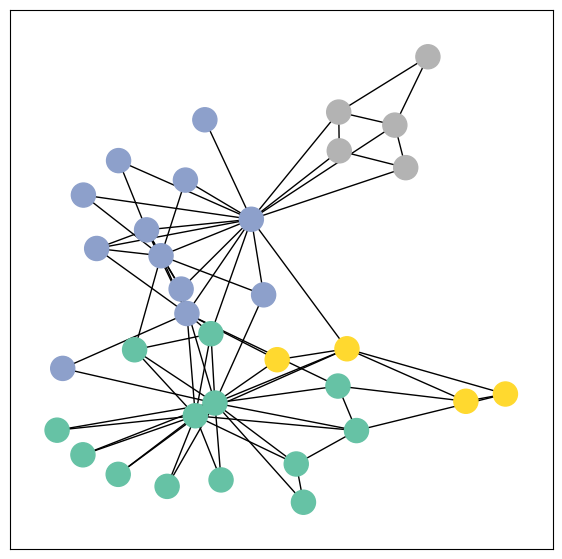

In [5]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Implementing Graph Neural Networks

在了解了PyG的数据处理后，是时候实现我们的第一个图神经网络了！

为此，我们将使用最简单的图神经网络（GNN）之一——**图卷积网络（GCN）层**（[基普夫等人（2017年）](https://arxiv.org/abs/1609.02907)），其定义为：

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathbf{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

其中$\mathbf{W}^{(\ell + 1)}$表示一个形状为`[num_output_features, num_input_features]`的可训练权重矩阵，$c_{w,v}$指的是每条边的固定归一化系数。

PyG通过[`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)实现此层，该层可通过传入节点特征表示`x`和COO图连通性表示`edge_index`来执行。

有了这些，我们就可以通过在`torch.nn.Module`类中定义网络架构来创建我们的第一个图神经网络了：

In [6]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


在这里，我们首先在`__init__`中初始化所有构建模块，并在`forward`中定义网络的计算流程。

我们首先定义并堆叠**三个图卷积层**，这相当于聚合每个节点周围3跳的邻域信息（所有距离节点3“跳”以内的节点）。
此外，`GCNConv`层将节点特征维度降至2，即$34 \rightarrow 4 \rightarrow 4 \rightarrow 2$。每个`GCNConv`层都通过一个tanh进行增强。

之后，我们应用一个单一的线性变换（[`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)），它作为一个分类器，将我们的节点映射到4个类别/社区中的1个。

我们返回最终分类器的输出以及由我们的图神经网络（GNN）生成的最终节点嵌入。
我们通过`GCN()`初始化最终模型，打印模型会生成其所有使用的子模块的摘要。


### Embedding the Karate Club Network

让我们看看由我们的图神经网络（GNN）生成的节点嵌入。
在这里，我们将初始节点特征`x`和图连接信息`edge_index`传入模型，并可视化其二维嵌入。

Embedding shape: [34, 2]


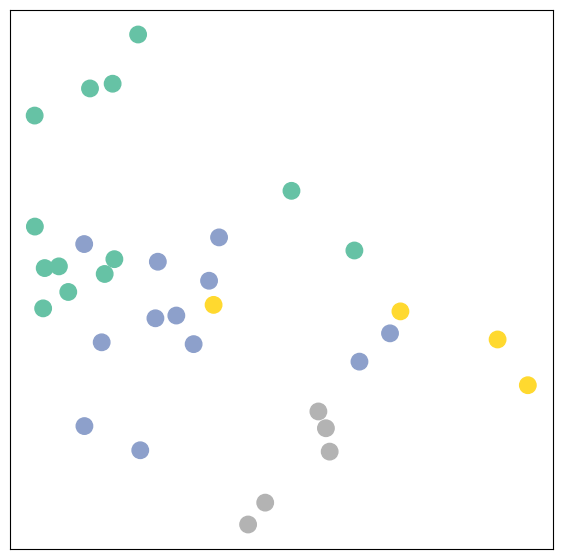

In [7]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

值得注意的是，甚至在训练我们模型的权重之前，该模型就能生成与图的社区结构极为相似的节点嵌入。
尽管我们模型的权重是**完全随机初始化**的，并且截至目前我们尚未进行任何训练，但相同颜色（社区）的节点在嵌入空间中已然紧密聚集在一起！
由此得出结论，图神经网络（GNNs）引入了一种强大的归纳偏置，使得在输入图中彼此靠近的节点具有相似的嵌入。

### Training on the Karate Club Network

但是我们能做得更好吗？让我们来看一个示例，了解如何基于图中4个节点（每个社区一个）的社区分配信息来训练我们的网络参数：

由于我们模型中的所有内容都是可微且参数化的，因此我们可以添加一些标签，训练模型并观察嵌入如何反应。
在此，我们采用半监督或直推式学习过程：我们仅针对每个类别中的一个节点进行训练，但可以使用完整的输入图数据。

训练我们的模型与任何其他PyTorch模型非常相似。
除了定义我们的网络架构外，我们还定义一个损失准则（此处为[`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)），并初始化一个随机梯度优化器（此处为[`Adam`](https://pytorch.org/docs))

在此之后，我们进行多轮优化，每一轮都包含一次前向传播和一次反向传播，以计算模型参数相对于前向传播得出的损失的梯度。
如果你对PyTorch并不陌生，这种方法对你来说应该很熟悉。
否则，PyTorch文档提供了[关于如何在PyTorch中训练神经网络的精彩介绍](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer)。

请注意，我们的半监督学习场景是通过以下代码行实现的：
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
虽然我们为所有节点计算节点嵌入，但**仅使用训练节点来计算损失**。
在此，这是通过过滤分类器的输出`out`和真实标签`data.y`来实现的，使其仅包含`train_mask`中的节点。

现在让我们开始训练，看看我们的节点嵌入如何随时间演变（通过显式运行代码能获得最佳体验）：

<IPython.core.display.Javascript object>

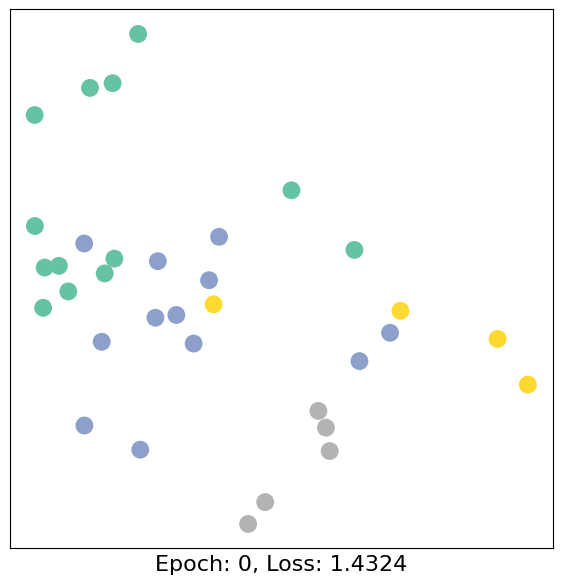

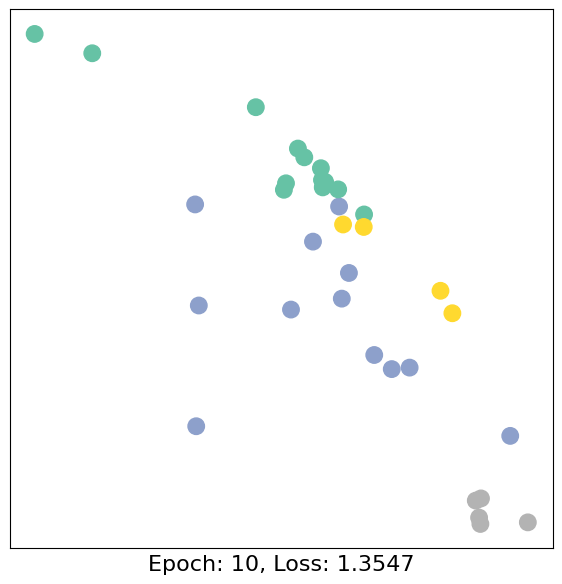

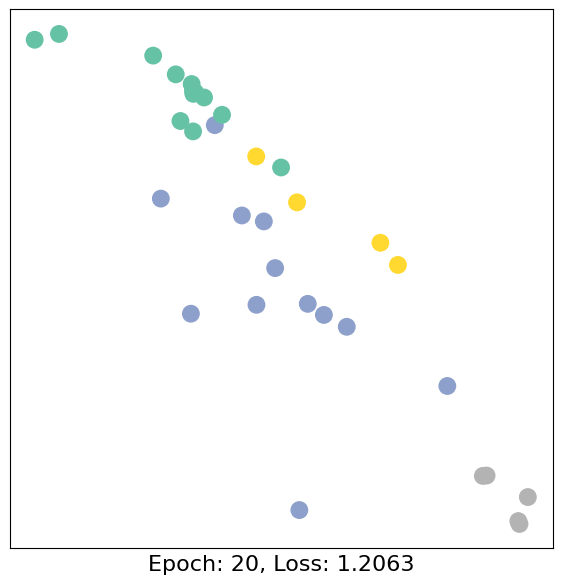

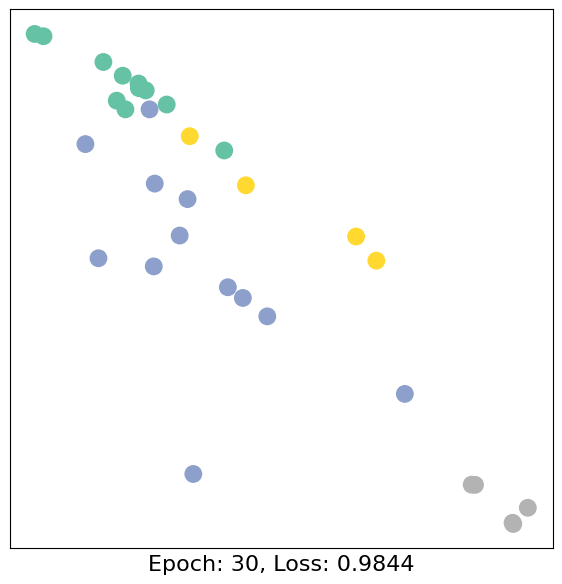

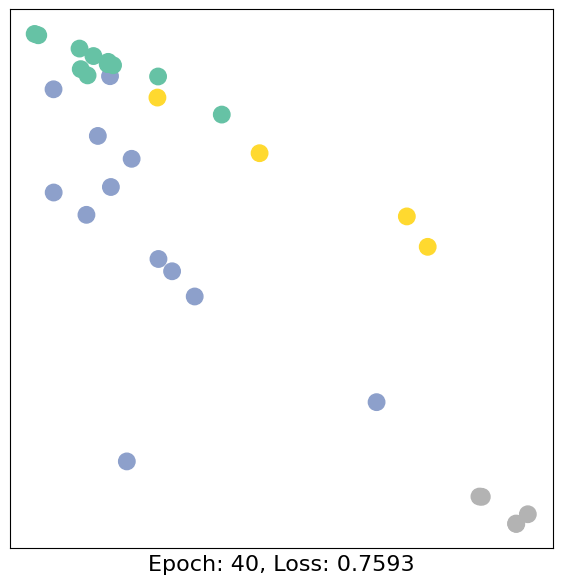

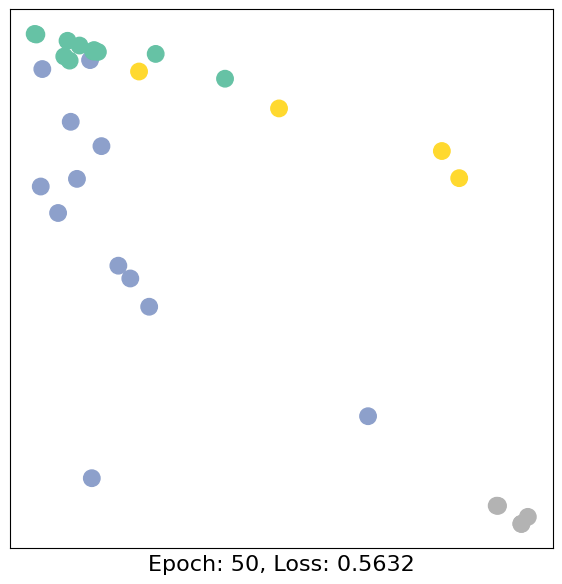

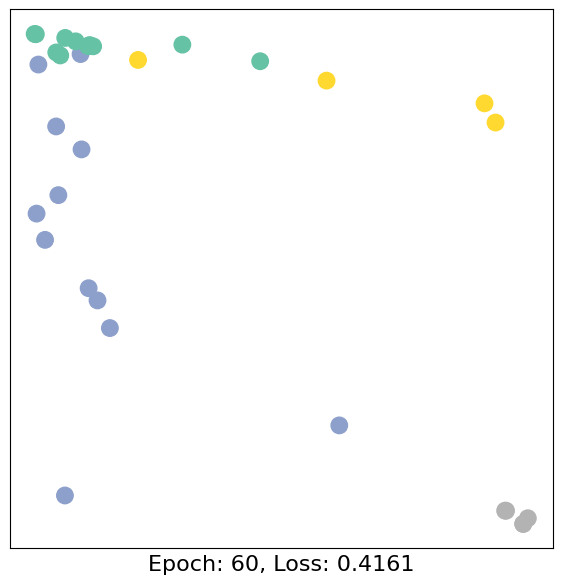

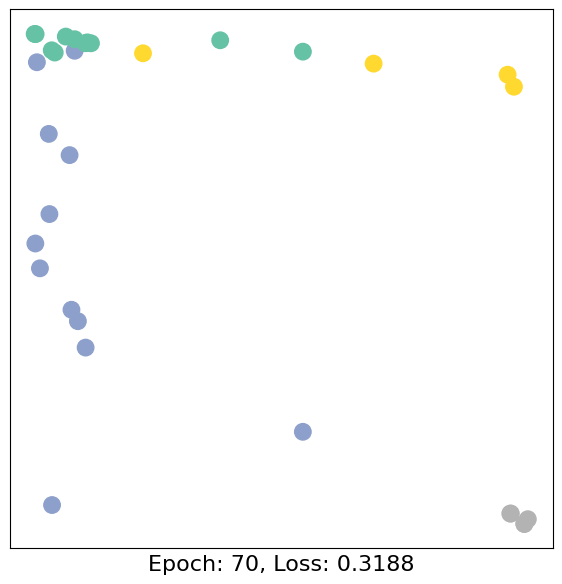

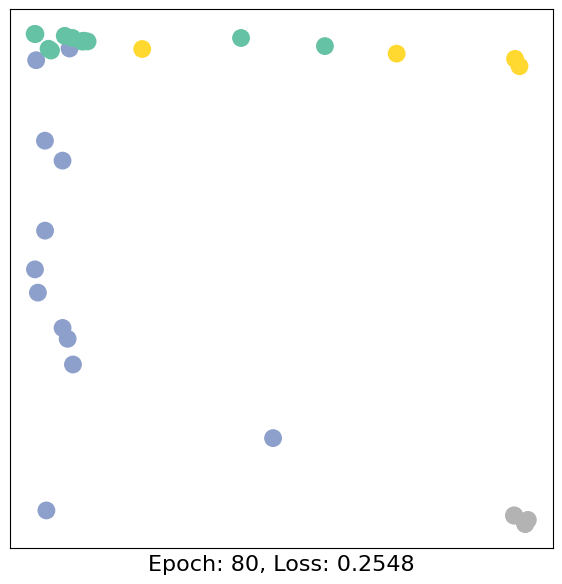

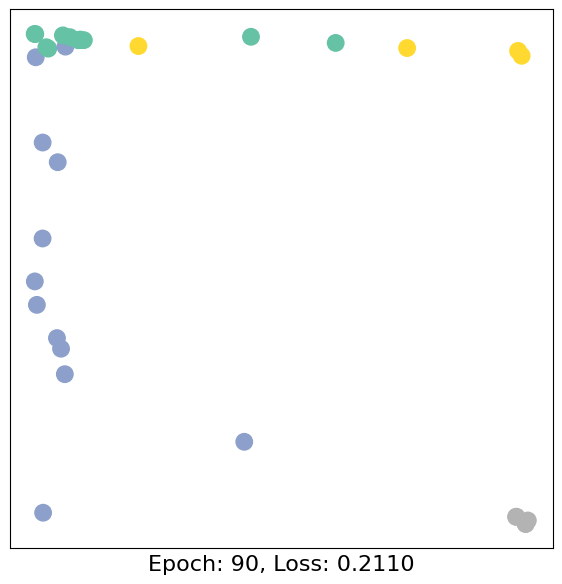

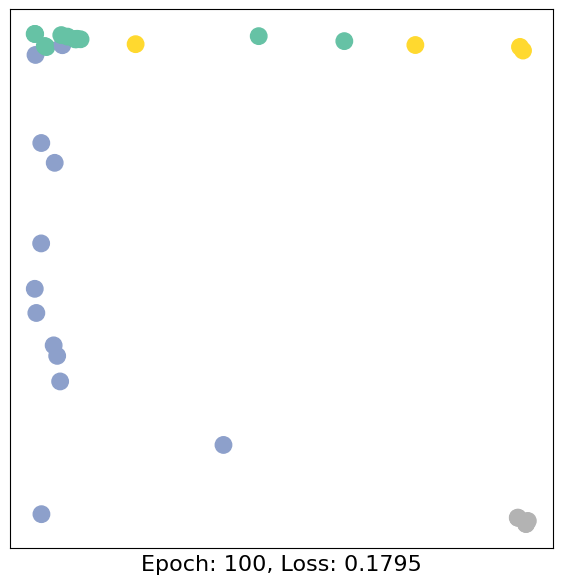

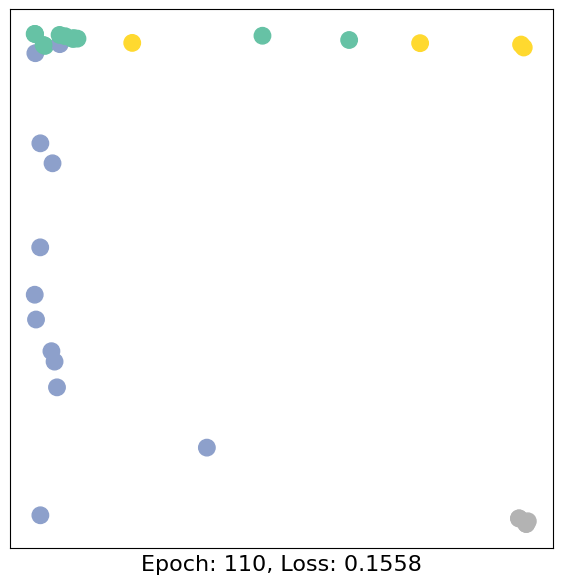

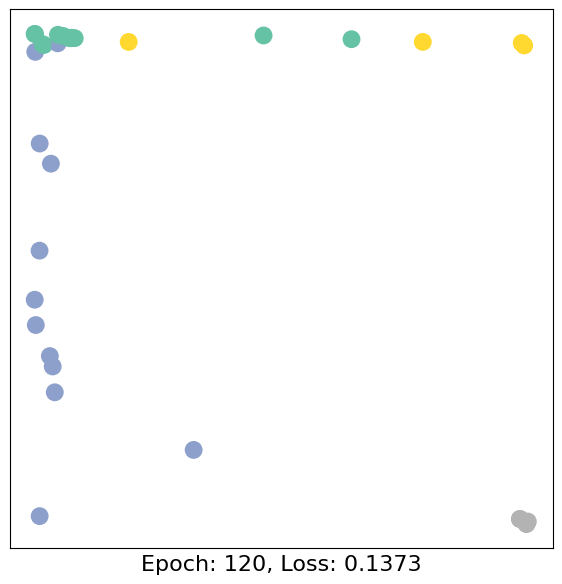

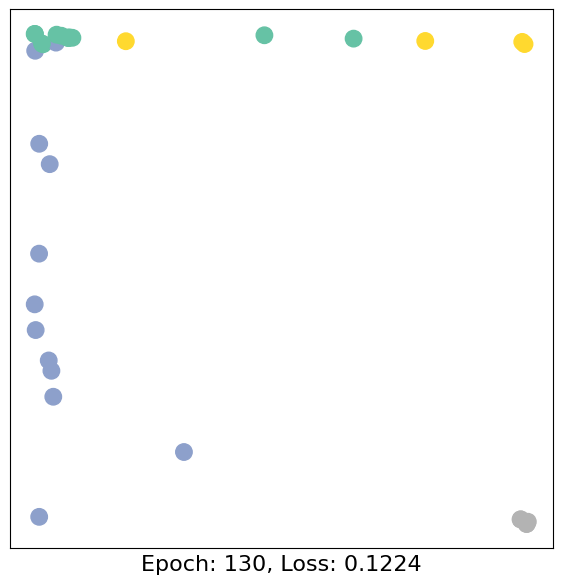

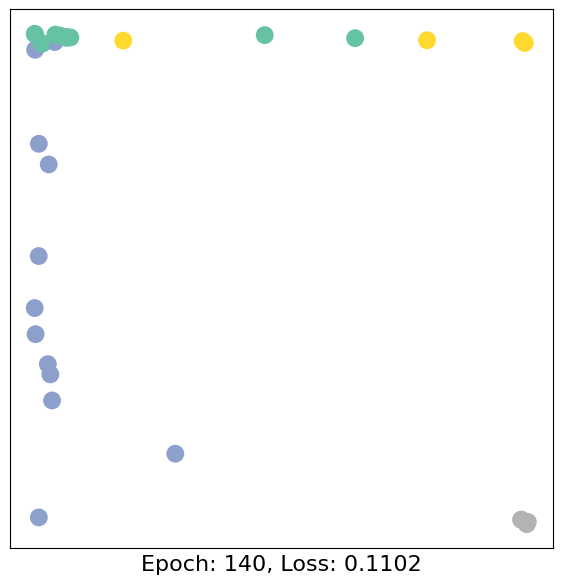

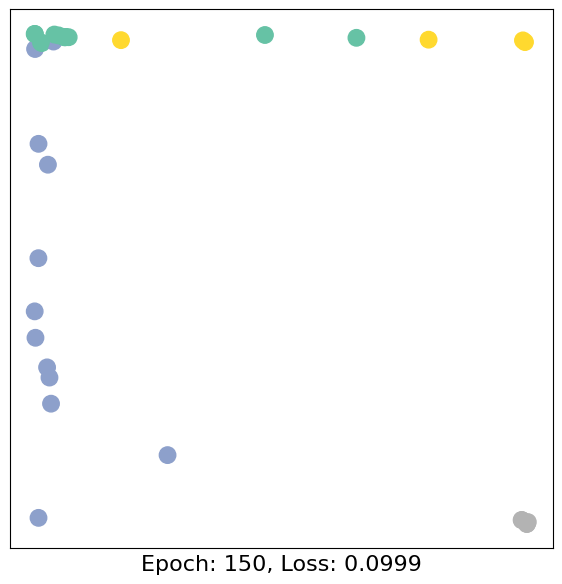

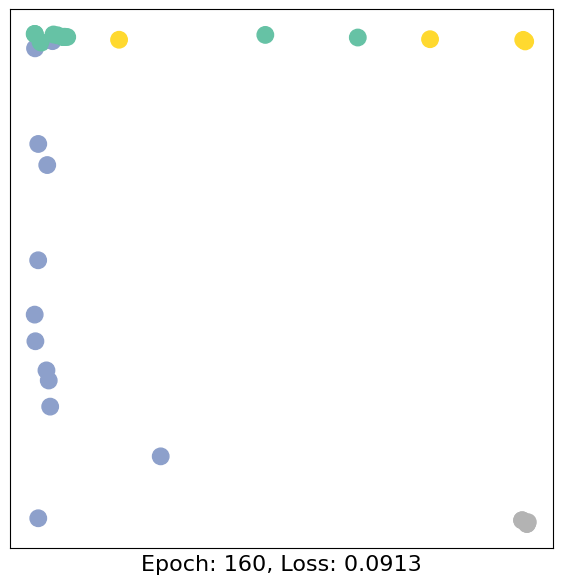

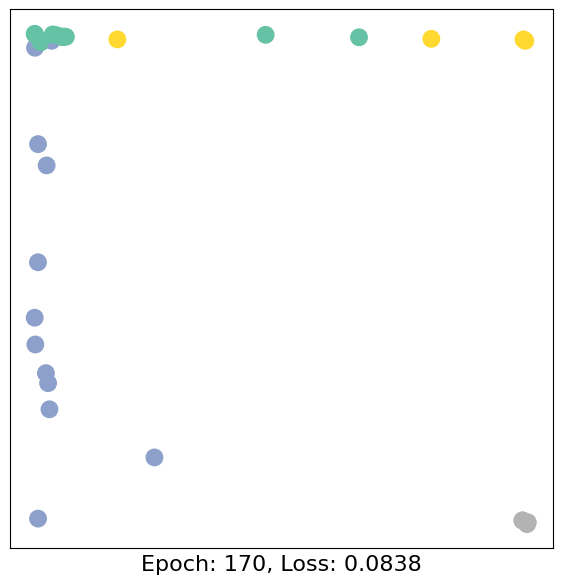

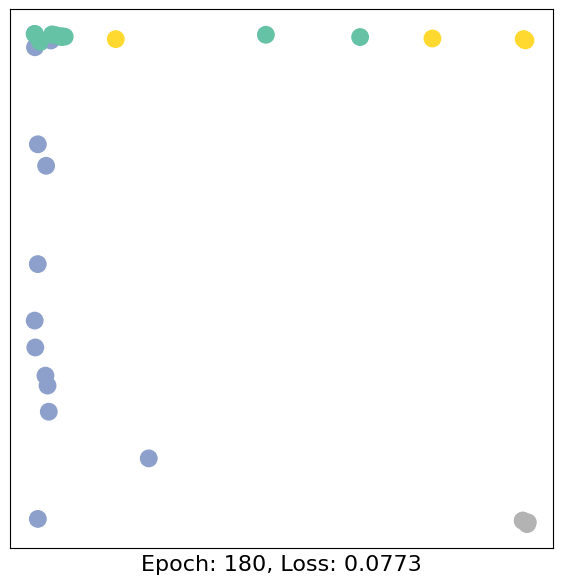

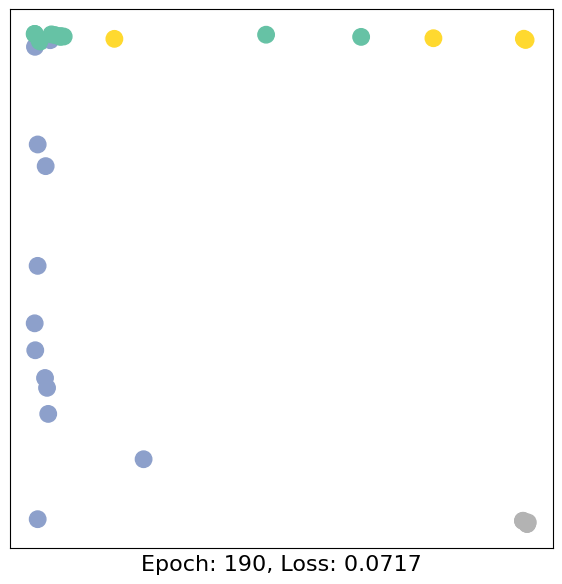

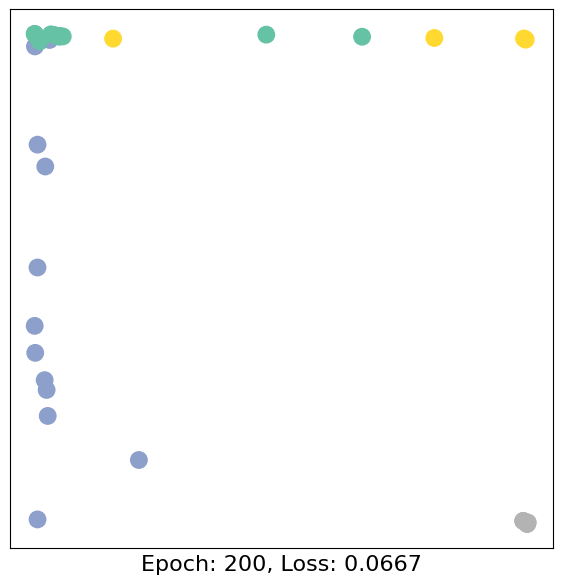

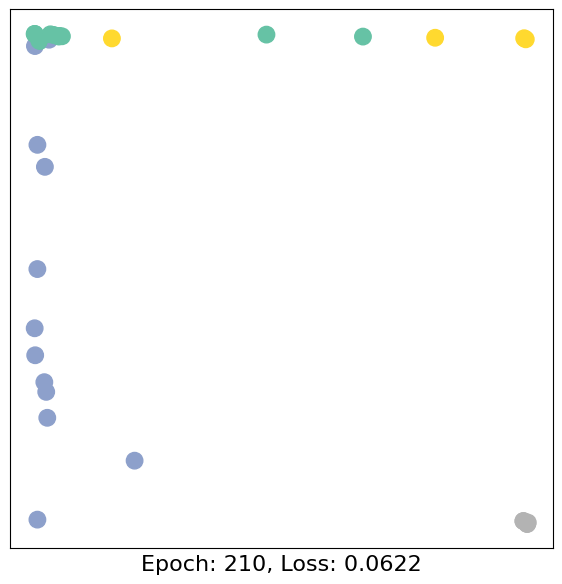

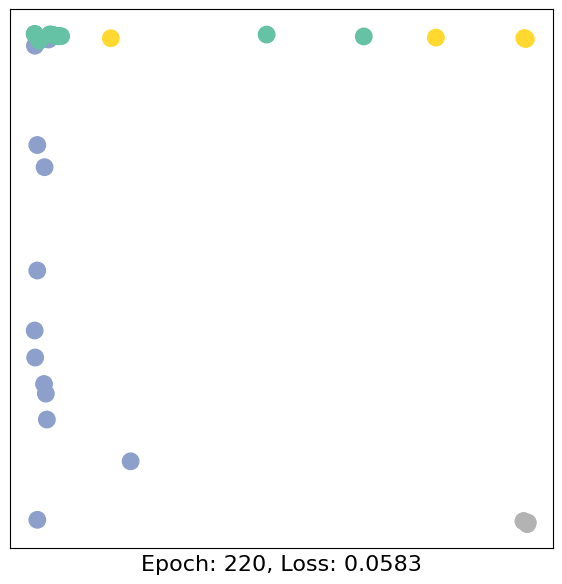

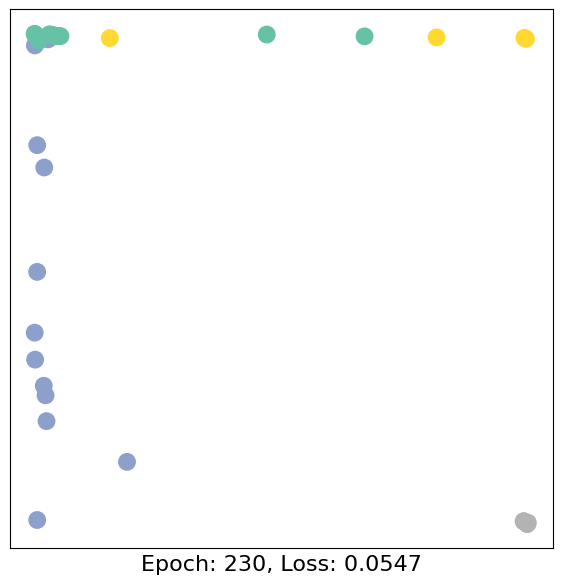

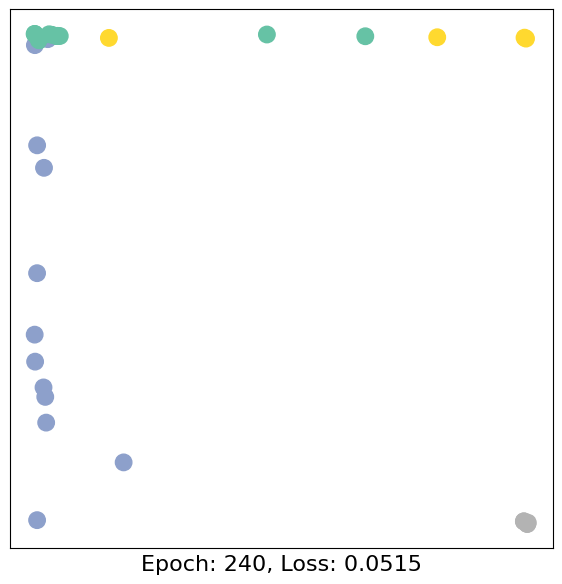

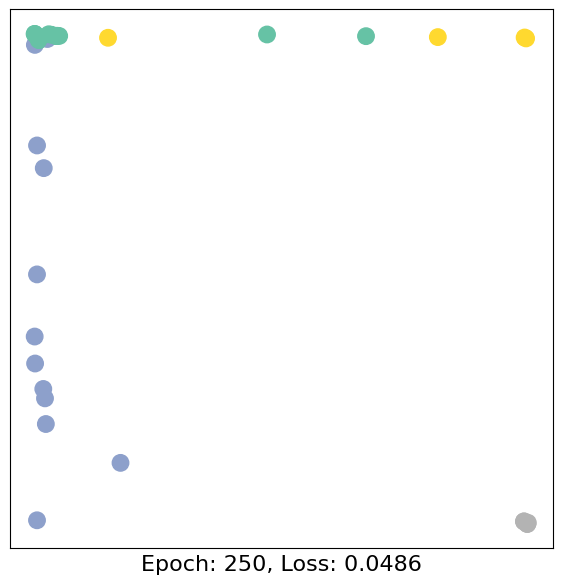

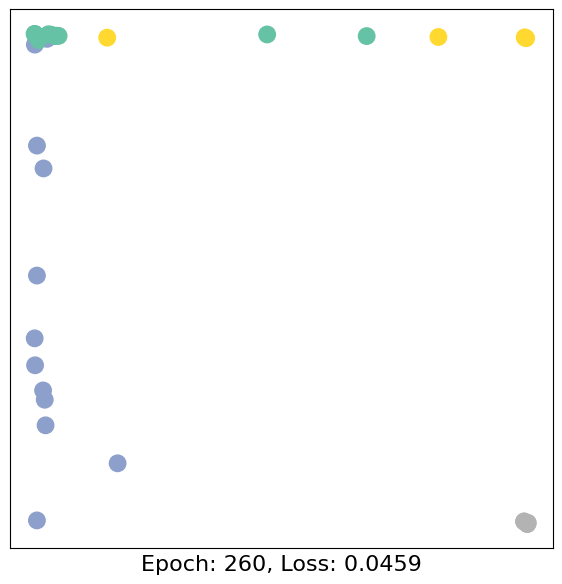

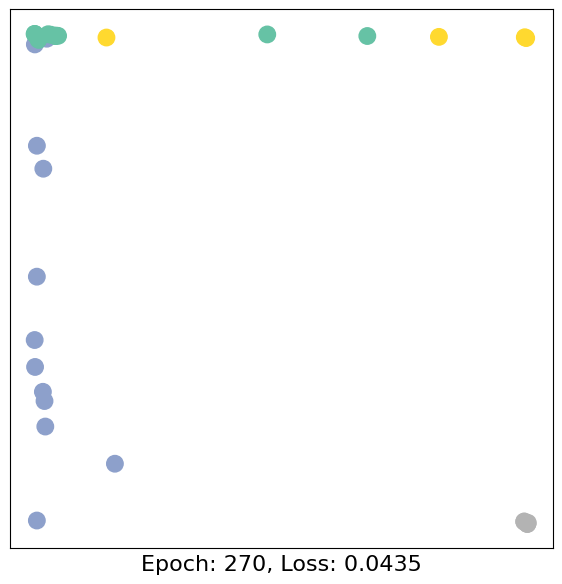

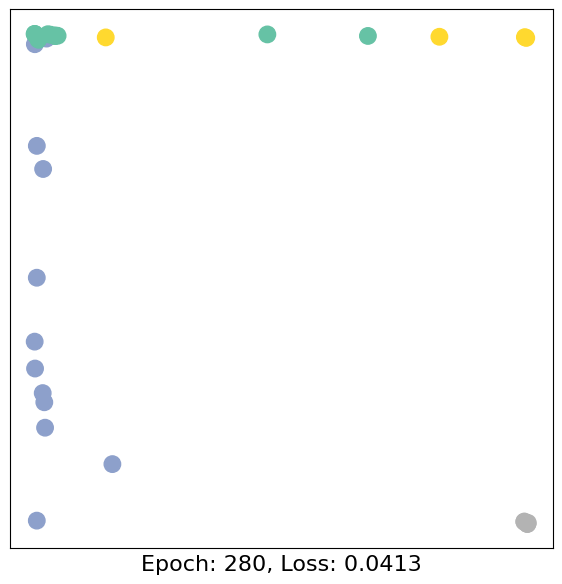

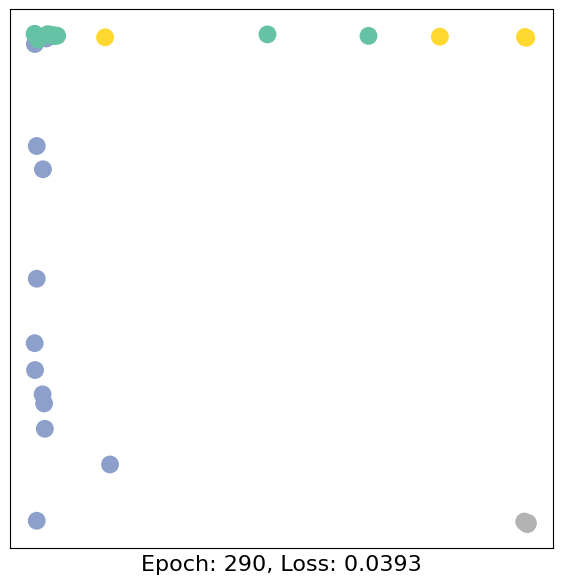

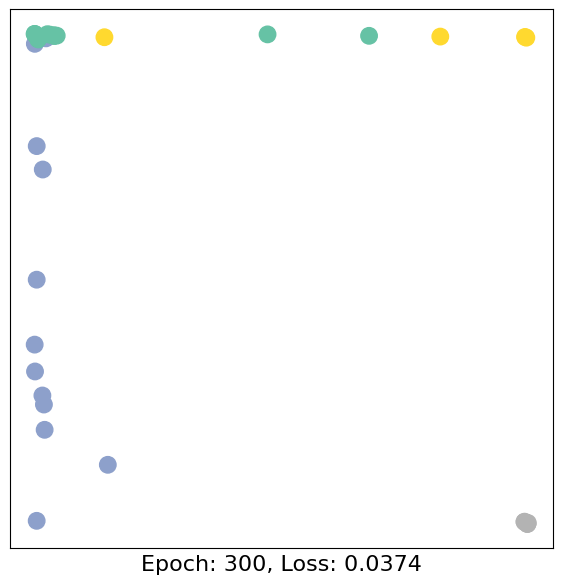

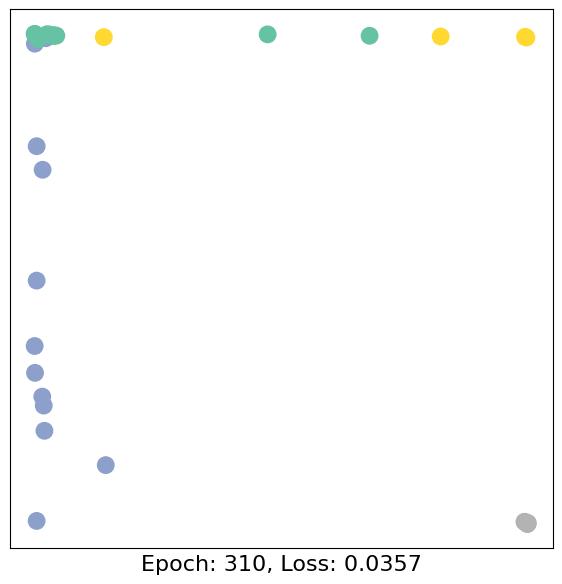

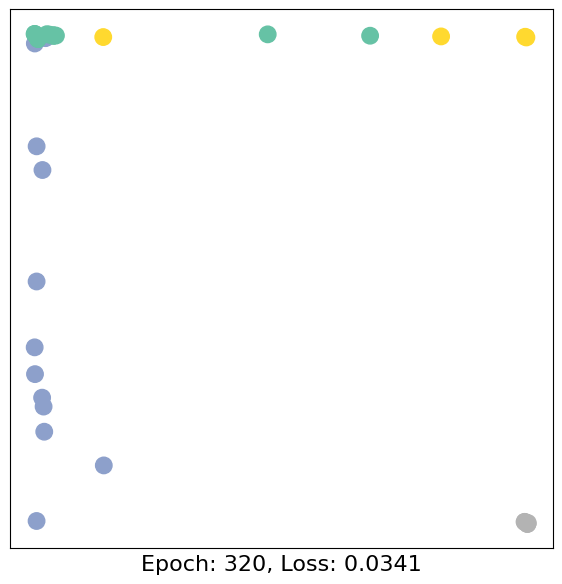

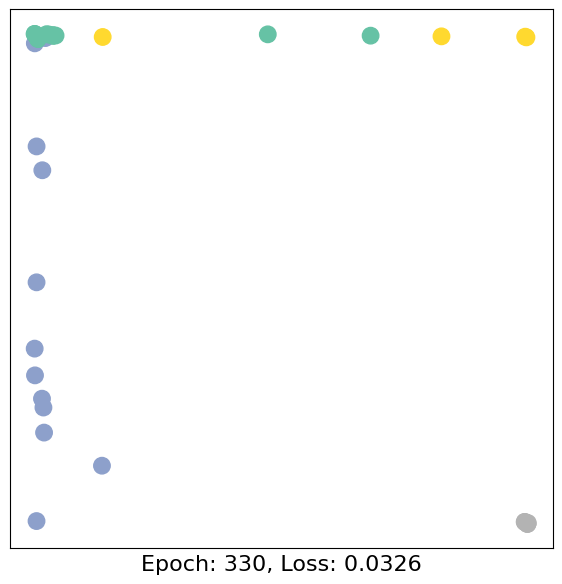

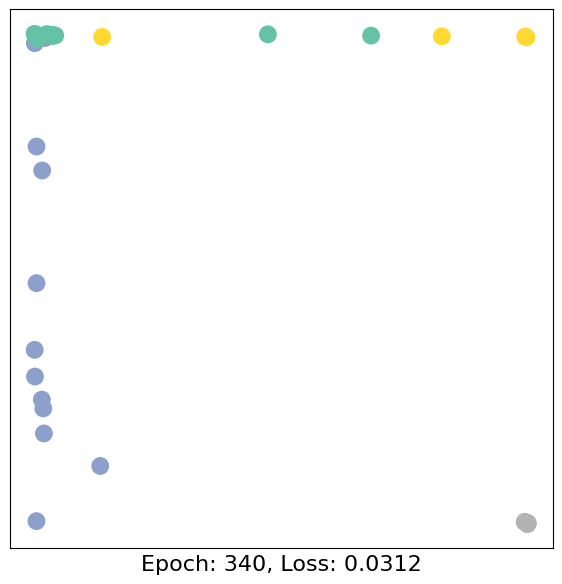

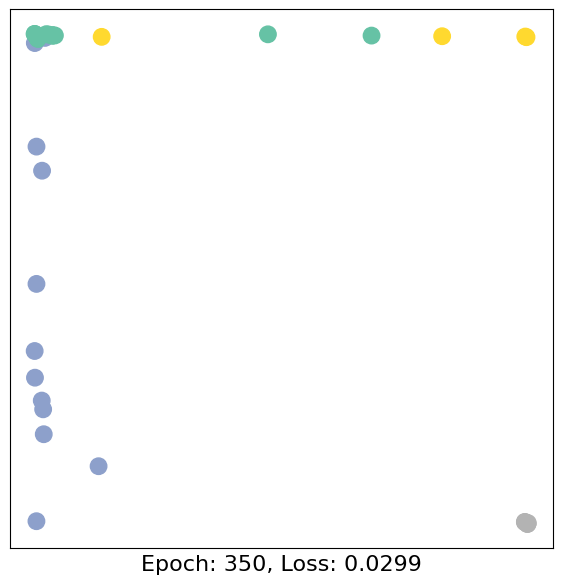

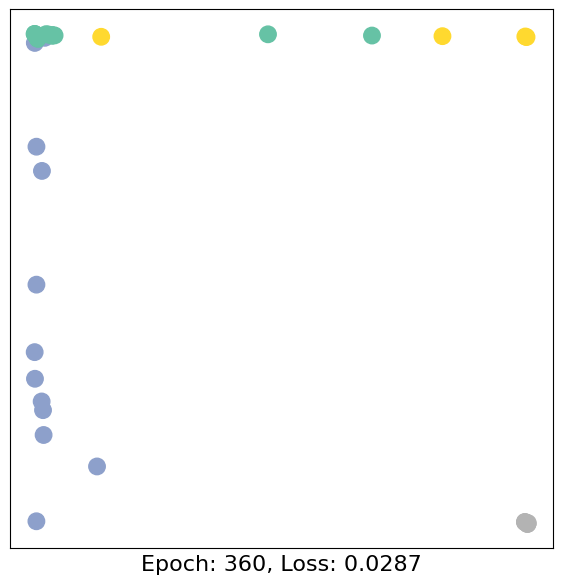

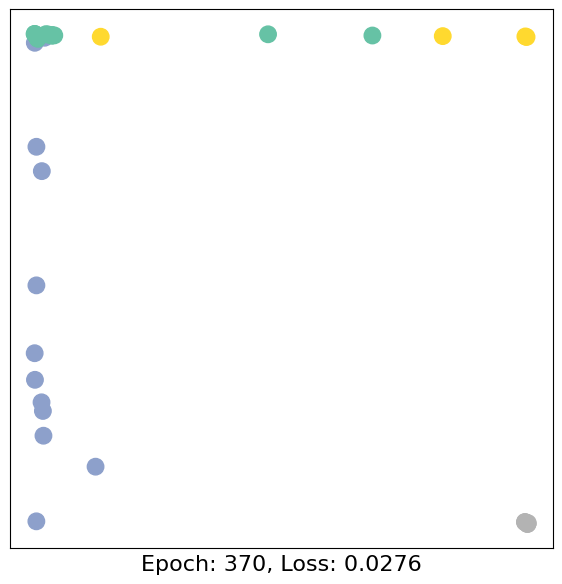

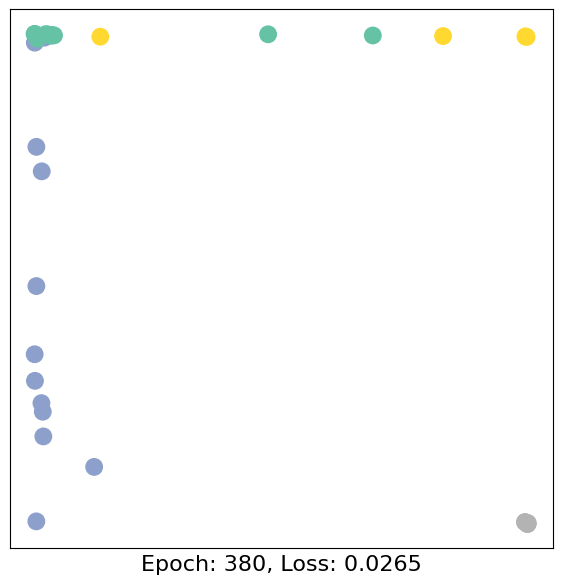

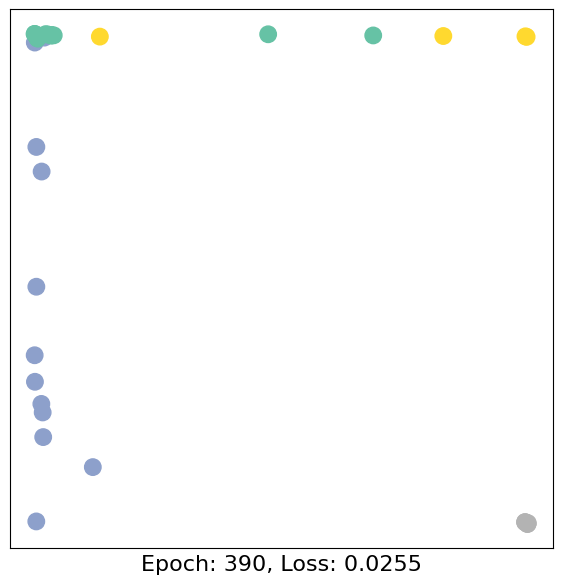

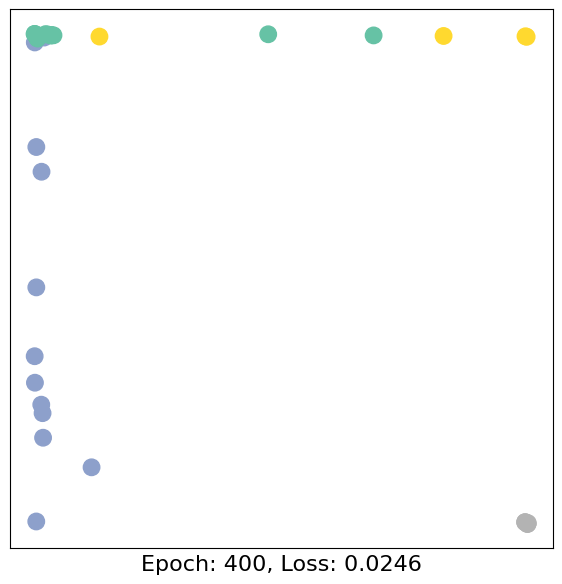

In [9]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

如大家所见，我们的三层图卷积网络（GCN）模型成功地对各个社区进行了线性分离，并正确分类了大多数节点。

此外，多亏了PyTorch Geometric库帮助我们处理数据和实现图神经网络（GNN），我们仅用几行代码就完成了这一切。

## 结论

这就完成了对图神经网络（GNN）和PyTorch Geometric的首次介绍。
在后续课程中，你们将学习如何在一些真实世界的图数据集上取得最先进的分类结果。

[下一篇：使用图神经网络进行节点分类](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)